# WANN experiments on Toy dataset

In [1]:
import copy
import sys

import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.base import clone
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.constraints import MinMaxNorm
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import Adam

sys.path.append("../wann")
from methods.KLIEP import KLIEP
from methods.KMM import KMM
from methods.TrAdaBoostR2 import TwoStageTrAdaBoostR2
from methods.WANN import WANN

from warnings import filterwarnings
filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Toy experiment Set Up

In [2]:
def toy_function_source(X, d=1, random_state=None):
    np.random.seed(random_state)
    k = np.linspace(-1, 1, 5) * 2
    y = np.array([])
    for i in range(5):
        y_i = k[i] * (X+0.5)**3 + np.sin(20 * (X+0.5)) + np.random.randn(len(X)) * 0.1
        y = np.concatenate((y, y_i))
    return y

def toy_function_target(X, noise=0.1, random_state=None):
    np.random.seed(random_state)
    return np.sin(20 * (X+0.5)) + np.random.randn(len(X)) * noise - 0.75 * (X+0.5)**3

In [3]:
def toy_dataset(n_samples=500, n_target_train=10, random_state=None):
    X_source = np.linspace(-0.5, 0.5, int(n_samples/5))
    X_target = np.linspace(-0.5, 0.5, n_samples)
    y_source = toy_function_source(X_source, random_state=random_state)
    y_target = toy_function_target(X_target, random_state=random_state)
    X_source = np.array(list(X_source) * 5)
    X_target_train = np.linspace(-0.5, 0.5, n_target_train)
    y_target_train = toy_function_target(X_target_train, noise=0.3, random_state=random_state)
    
    X = np.concatenate((X_source, X_target, X_target_train))
    y = np.concatenate((y_source, y_target, y_target_train))
    
    src_index = np.array([i for i in range(n_samples)])
    tgt_index = np.array([i for i in range(n_samples, 2 * n_samples)])
    tgt_train_index = np.array([i for i in range(2 * n_samples, 2 * n_samples + n_target_train)])
    train_index = np.concatenate((src_index, tgt_train_index))
    
    return X, y, src_index, tgt_index, tgt_train_index, train_index

In [4]:
def get_base_model(shape=1, activation=None, C=10, name="BaseModel"):
    inputs = Input(shape=(shape,))
    modeled = Dense(100, activation='relu',
                         kernel_constraint=MinMaxNorm(0, C),
                         bias_constraint=MinMaxNorm(0, C))(inputs)
    modeled = Dense(100, activation='relu',
                         kernel_constraint=MinMaxNorm(0, C),
                         bias_constraint=MinMaxNorm(0, C))(modeled)
    modeled = Dense(1, activation=activation,
                    kernel_constraint=MinMaxNorm(0, C),
                    bias_constraint=MinMaxNorm(0, C),
                    bias_initializer="ones")(modeled)
    model = Model(inputs, modeled)
    model.compile(optimizer=Adam(0.01), loss='mean_squared_error')
    return model

## Load Dataset

In [5]:
X, y, src_index, tgt_index, tgt_train_index, train_index = toy_dataset(random_state=0)
X = X.reshape(-1, 1)

base_estimator = KerasRegressor(get_base_model, C=10, shape=1,
                                epochs=300, batch_size=64, verbose=0)
random_state = 0

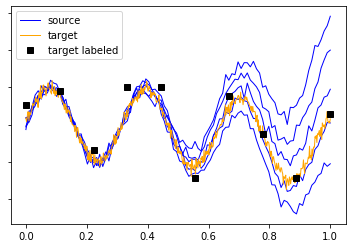

In [6]:
def pb_setup(ax=plt.gca()):
    for j in range(5):
        if j == 0:
            ax.plot(X[100*j:100*j+100]+0.5, y[100*j:100*j+100], c='blue', linewidth=1, label="source")
        else:
            ax.plot(X[100*j:100*j+100]+0.5, y[100*j:100*j+100], c='blue', linewidth=1)
    ax.plot(X[tgt_index]+0.5, y[tgt_index], c='orange', linewidth=1, label="target")
    ax.plot(X[tgt_train_index]+0.5, y[tgt_train_index], 's', c='black', label="target labeled")
    ax.set_yticklabels([])
    return ax
pb_setup()
plt.legend()
plt.show()

## Examples

### Target Only

In [7]:
np.random.seed(random_state)
tf.random.set_seed(random_state)

tgt_only = clone(base_estimator)
tgt_only.fit(X[tgt_train_index], y[tgt_train_index])

y_pred = tgt_only.predict(X)
score= mean_squared_error(y[tgt_index], y_pred[tgt_index])
print('Target score: %.3f'%score)

Target score: 0.175


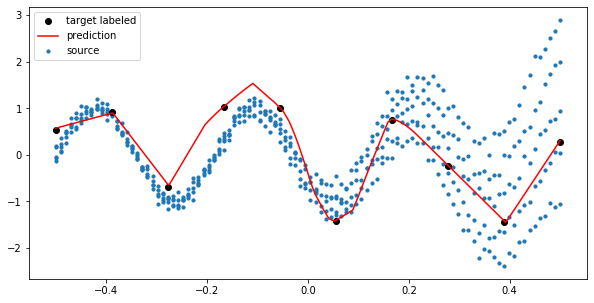

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
y_pred = tgt_only.predict(X)
score = mean_squared_error(y[tgt_index], y_pred[tgt_index])

ax.scatter(X.ravel()[src_index], y[src_index], label="source", s=10)
ax.plot(X.ravel()[tgt_train_index], y[tgt_train_index], 'o', c='black', label='target labeled')
ax.plot(X[tgt_index], y_pred[tgt_index], c="red", label="prediction")
ax.legend()
ax.plot()
plt.show()

### No reweight

In [9]:
np.random.seed(random_state)
tf.random.set_seed(random_state)

no_reweight = clone(base_estimator)
no_reweight.fit(X[src_index], y[src_index])

y_pred = no_reweight.predict(X)
score= mean_squared_error(y[tgt_index], y_pred[tgt_index])
print('Target score: %.3f'%score)

Target score: 0.119


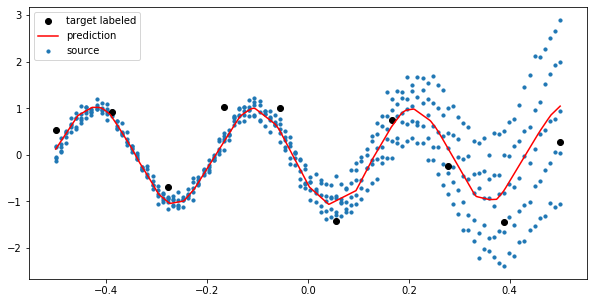

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
y_pred = no_reweight.predict(X)
score = mean_squared_error(y[tgt_index], y_pred[tgt_index])

ax.scatter(X.ravel()[src_index], y[src_index], label="source", s=10)
ax.plot(X.ravel()[tgt_train_index], y[tgt_train_index], 'o', c='black', label='target labeled')
ax.plot(X[tgt_index], y_pred[tgt_index], c="red", label="prediction")
ax.legend()
ax.plot()
plt.show()

### TrAdaBoostR2

In [11]:
np.random.seed(random_state)
tf.random.set_seed(random_state)

if len(tgt_train_index) == 0:
    print("TradaBoostR2 needs labeled target data")
else:
    tradaboost = TwoStageTrAdaBoostR2(base_estimator, n_estimators=10, fold=5, stage=1, verbose=1)
    tradaboost.fit(X, y, [src_index, tgt_train_index])
    y_pred = tradaboost.predict(X)
    score= mean_squared_error(y[tgt_index], y_pred[tgt_index])
    print('Target score: %.3f'%score)

cv error of estimator 0: 0.344 (0.3127171304)
cv error of estimator 1: 0.357 (0.3687555831)
cv error of estimator 2: 0.254 (0.1535874238)
cv error of estimator 3: 0.807 (1.3157370333)
cv error of estimator 4: 0.838 (1.4224688011)
cv error of estimator 5: 0.797 (1.3166620082)
cv error of estimator 6: 0.821 (1.2797837433)
cv error of estimator 7: 0.926 (1.4141482103)
cv error of estimator 8: 1.600 (1.4849726459)
cv error of estimator 9: 2.555 (2.2786465721)
Target score: 0.041


[]

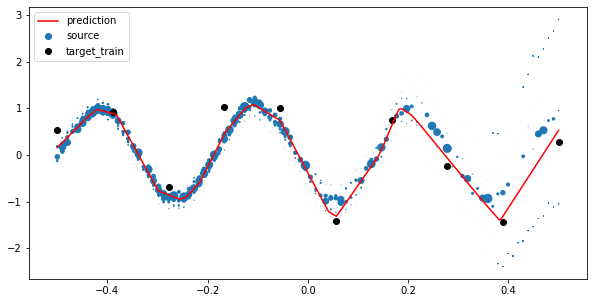

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
weight = tradaboost.sample_weights_[np.argmin(tradaboost.estimator_errors_)][:len(src_index)]
weight = (weight - weight.min()*0.99)
weight = 10 * len(weight) * np.array(weight)/np.sum(np.array(weight))
y_pred = tradaboost.predict(X)
score = mean_squared_error(y[tgt_index], y_pred[tgt_index])

ax.scatter(X.ravel()[src_index], y[src_index], label="source", s=weight)
ax.scatter(X.ravel()[tgt_train_index], y[tgt_train_index], marker='o', c='black', label='target_train')
ax.plot(X[tgt_index], y_pred[tgt_index], c="red", label="prediction")
ax.legend()
ax.plot()

### WANN

In [42]:
np.random.seed(random_state)
tf.random.set_seed(random_state)

wann = WANN(get_base_model=get_base_model, C=10, optimizer=Adam(0.0005))
wann.fit(X, y, index=[src_index, tgt_train_index],
         epochs=1000, batch_size=64, verbose=0)

y_pred = wann.predict(X)
score = mean_squared_error(y[tgt_index], y_pred[tgt_index])
print('Target score: %.3f'%score)

Target score: 0.040


[]

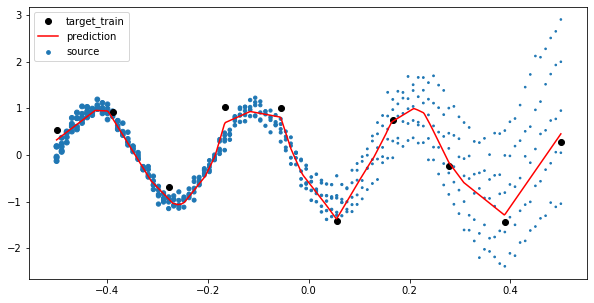

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

weight = wann.get_weight(X[src_index])
weight = 10 * len(weight) * np.array(weight)/np.sum(np.array(weight))
y_pred = wann.predict(X)
score = mean_squared_error(y[tgt_index], y_pred[tgt_index])

ax.scatter(X.ravel()[src_index], y[src_index], label="source", s=weight[src_index])
ax.plot(X.ravel()[tgt_train_index], y[tgt_train_index], 'o', c='black', label='target_train')
ax.plot(X[tgt_index], y_pred[tgt_index], c="red", label="prediction")
ax.legend()
ax.plot()

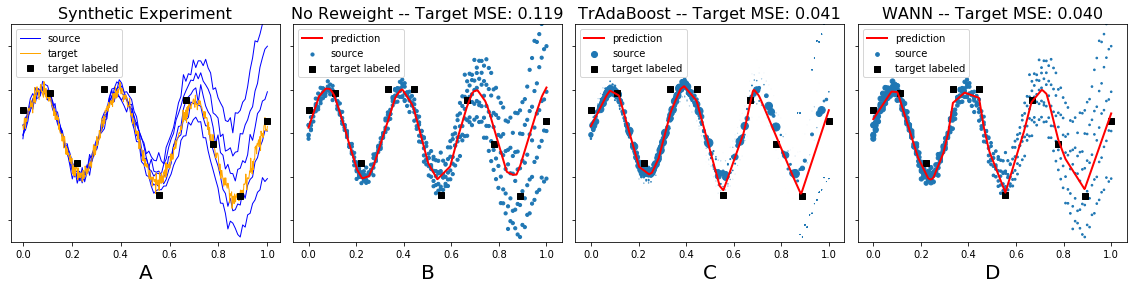

In [15]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

models = ["setup", no_reweight, tradaboost, wann]
names = ["setup", "No Reweight", "TrAdaBoost", "WANN"]
letters = ["A", "B", "C", "D"]
weights = [
    "setup",
    np.ones(len(train_index)),
    tradaboost.sample_weights_[np.argmin(tradaboost.estimator_errors_)][:len(src_index)],
    wann.get_weight(X[src_index])
            ]
for ax, model, weight, name, letter in zip(axes.ravel(), models, weights, names, letters):
    if name == "setup":
        pb_setup(ax)
        ax.set_title("Synthetic Experiment", fontsize=16)
    else:
        #weight = (weight - weight.min()*0.99)
        weight = 10 * len(weight) * np.array(weight)/np.sum(np.array(weight))
        y_pred = model.predict(X)
        score = mean_squared_error(y[tgt_index], y_pred[tgt_index])

        ax.scatter(X.ravel()[src_index]+0.5, y[src_index], label="source", s=10 *len(weight)*weight/weight.sum())
        ax.scatter(X.ravel()[tgt_train_index]+0.5, y[tgt_train_index], marker='s', c='black', label='target labeled')
        ax.plot(X[tgt_index]+0.5, y_pred[tgt_index], c="red", label="prediction", lw=2)
        ax.set_yticklabels([])
   
        
        ax.set_title("%s -- Target MSE: %.3f"%(name, score), fontsize=16)
    ax.set_ylim(-2.5, 2.5)
    ax.set_xlabel(letter, fontsize=20)
    ax.legend(prop={"size":10}, loc='upper left')
plt.subplots_adjust(wspace=0.05, hspace=0)